# Sim1 with C+LOO

In [1]:
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from doe_modules.design import CLOO, DOE
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import AbstractSimulator, Sim1, MLR

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    design: DOE = CLOO
    simulator: AbstractSimulator = Sim1
    run_names: list = [
        f"#{i + 1} ({'all factors' if i == 0 else f'X{i} KD'})" for i in range(9 + 1)
    ]
    preffix: str = ""
    suffix: str = ""

conf = Config()

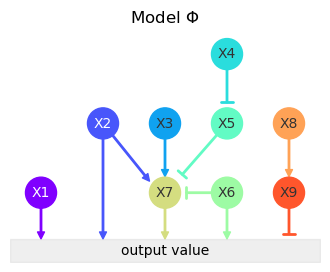

In [3]:
fig, ax = plt.subplots(figsize=(4, 3))

model = conf.simulator()
model.plot(ax=ax)
ax.set_title(model.name);

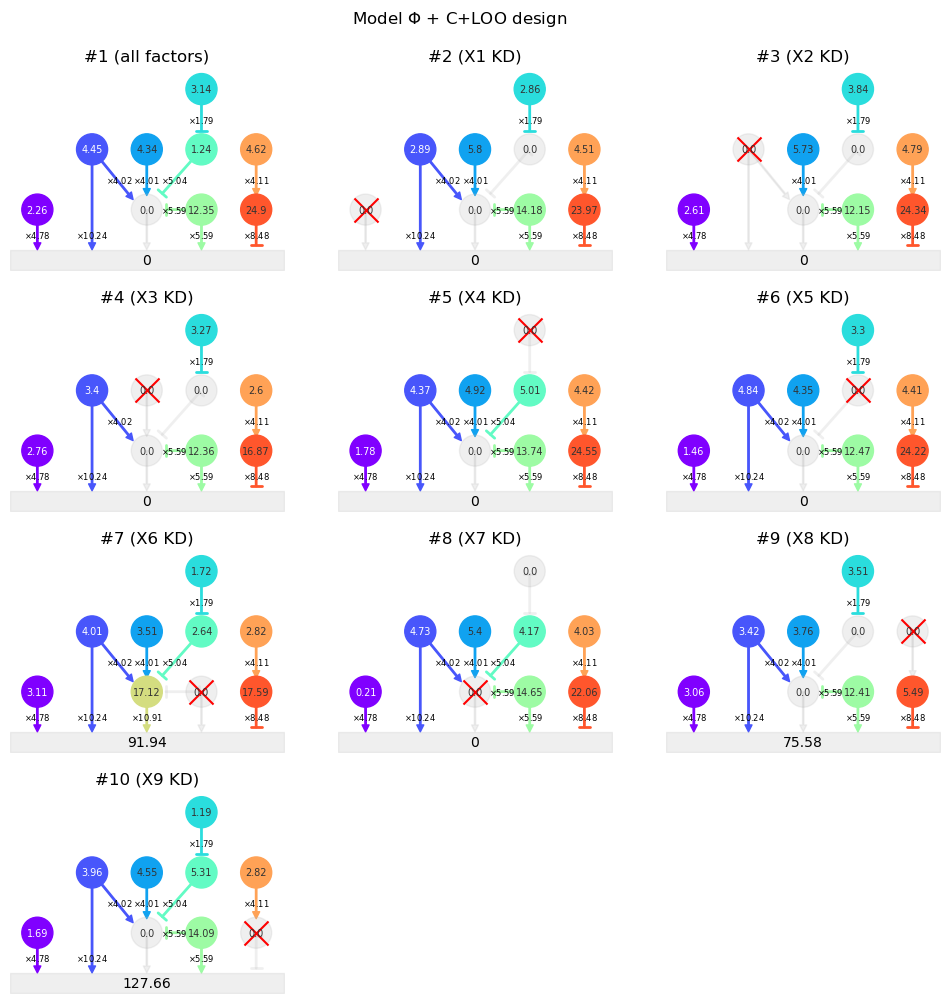

In [4]:
fig, ax = plt.subplots(4, 3, figsize=(12, 12))

model.simulate(
    design=conf.design, plot=True, ax=ax,
    titles=conf.run_names
)

fig.suptitle(f"{model.name} + {model.design().name} design", y=.93)

if conf.savefig:
    fig.savefig(f"{conf.out}/{conf.preffix}sim{conf.suffix}", **kwarg_savefig)

/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


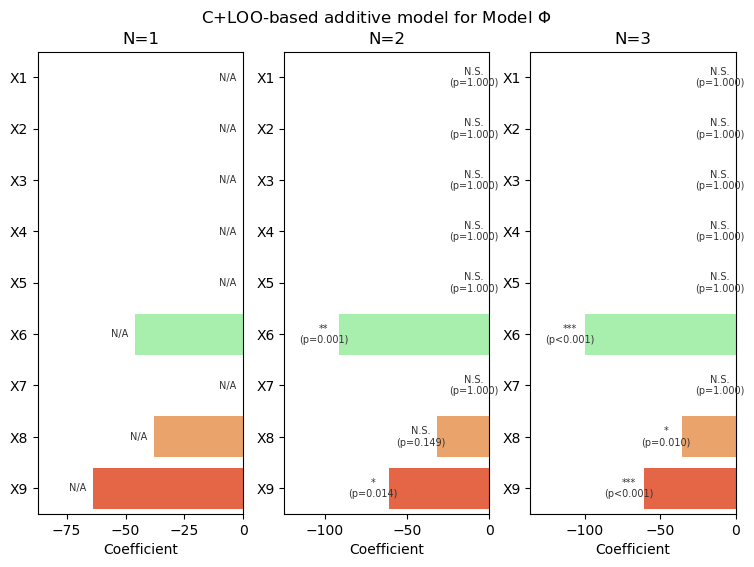

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(9, 6))

for i, a in enumerate(ax):
    model.simulate(n_rep=i + 1)
    mlr = MLR(model)
    mlr.plot(ax=a, anova=True)

fig.suptitle(f"{model.metadata['design']}-based additive model for {model.name}", y=.95)

if conf.savefig:
    fig.savefig(f"{conf.out}/{conf.preffix}sim_mlr{conf.suffix}", **kwarg_savefig)

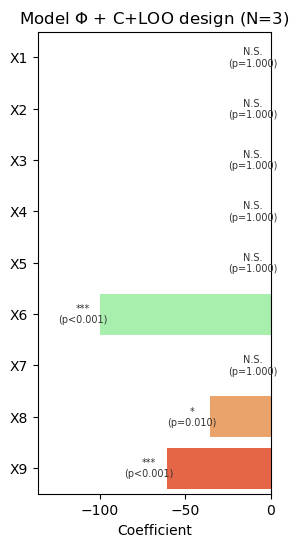

In [6]:
fig, ax = plt.subplots(figsize=(3, 6))

model.simulate(n_rep=3)
mlr = MLR(model)
mlr.plot(ax=ax, anova=True)

ax.set(title=f"{model.name} + {model.metadata['design']} design (N=3)")

if conf.savefig:
    fig.savefig(f"{conf.out}/{conf.preffix}sim_mlr_n=3{conf.suffix}", **kwarg_savefig)

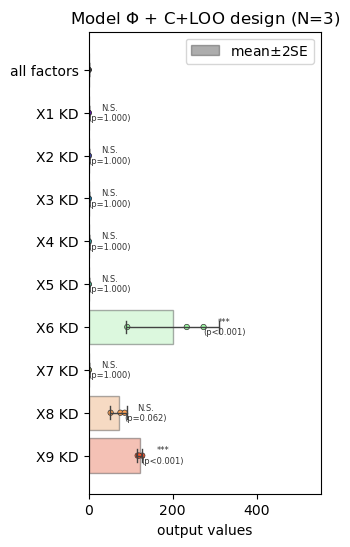

In [7]:
fig, ax = plt.subplots(figsize=(3, 6))

bio_multicomp(model, cmap=model.cmap, ax=ax, jitter_ratio=0.15, xscales=[1.6, 1.7])

ax.set(title=f"{model.name} + {model.metadata['design']} design (N=3)")

if conf.savefig:
    fig.savefig(f"{conf.out}/sim_res_n={model.metadata['n_rep']}_intuitive{conf.suffix}", **kwarg_savefig)

In [8]:
from scipy.stats import halfnorm

def half_normal(model):
    if isinstance(model.design, CLOO):
        standardized = (model.exresult[0] - model.exresult[1:]) / model.exresult[1:].std(ddof=1)
    else:
        n_rep = model.metadata["n_rep"]
        effects = np.array([
           model.exmatrix.assign(
               y=model.exresult
           ).groupby(colname).mean().y.diff()[1] for colname in model.exmatrix.columns
        ])
        standardized = np.sqrt(n_rep) * (effects - effects.mean()) / effects.std(ddof=1)
    df = pd.DataFrame({
        "abs_effects": np.abs(standardized),
        "factor_name": [f"X{i+1}" for i, _ in enumerate(standardized)],
        "original_order": np.arange(standardized.size)
    }).sort_values("abs_effects")
    return df.assign(
        half_score=[
            halfnorm.ppf((i + 1 - .5)/len(df)) for i in range(len(df))
        ]
    ).sort_values("original_order")

def half_normal_plot(model, ax, **kwargs):
    df = half_normal(model)
    for i, rowname in enumerate(df.index):
        ax.scatter(
            df.loc[rowname].half_score, 
            df.loc[rowname].abs_effects,
            color=model.cmap[i], marker=f"${df.loc[rowname].factor_name}$",
            **kwargs
        )
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(
        np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 100),
        np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 100),
        c=".2", zorder=-10, linewidth=1
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set(xlabel="Half-normal quantiles", ylabel="|Standardized effects|")

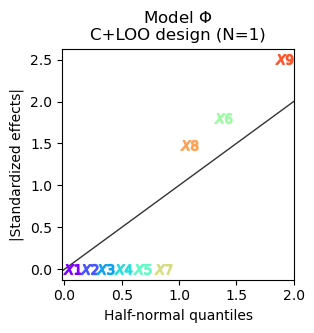

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))

model.simulate(n_rep=1)
half_normal_plot(model, ax, s=150)

ax.set(title=f"{model.name}\n{model.design().name} design (N={model.metadata['n_rep']})")

if conf.savefig:
    fig.savefig(f"{conf.out}/{conf.preffix}sim_halfnormal{conf.suffix}", **kwarg_savefig)